In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from src.models import TranAD, iTransformer
import torch

In [52]:
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', ['#17becf','#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.style.use([hep.style.ROOT, hep.style.firamath])
# plt.rcParams['lines.markersize'] = 5
# plt.rcParams['lines.linewidth'] = 3

### for first studies on importance of q and n_window

In [ ]:
iTransf_n_windows = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1000, 2000]
TranAD_n_windows = [10, 20, 30, 40, 50, 60, 70]

iTransf_q =  [0.5, 0.25, 0.1, 0.075, 0.05, 1e-2, 1e-3, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7]
TranAD_q = [0.5, 0.25, 0.1, 0.075, 0.05, 1e-2, 1e-3, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7]

In [ ]:
N = 25
dataset = 'SMAP_new'
less = False
plot_path = './studies2.3/plots'
studies_path = './studies2.3'

In [ ]:
loader = []
for file in ['train', 'test', 'labels']:
    if dataset == 'SMD': file = 'machine-1-1_' + file
    if dataset == 'SMAP': file = 'P-1_' + file
    if dataset == 'SMAP_new': file = 'P-1_' + file
    if dataset == 'MSL': file = 'C-1_' + file
    if dataset == 'MSL_new': file = 'C-1_' + file
    if dataset == 'UCR': file = '136_' + file
    if dataset == 'NAB': file = 'ec2_request_latency_system_failure_' + file
    loader.append(np.load(os.path.join(f'processed/{dataset}', f'{file}.npy')))
train_data = loader[0]
test_data = loader[1]
true_labels = loader[2]
print(train_data, train_data[0].shape, train_data.shape)
print(test_data, test_data[0].shape)

In [ ]:
TranAD_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
TranAD_labels = []
loss = np.zeros((len(TranAD_n_windows), N))

print(loss.shape, loss[0].shape)
for i, elem in enumerate(TranAD_n_windows):
    path = f'{studies_path}/TranAD_{dataset}_2/n_window{elem}/results'
    model_path = f'{studies_path}/n_window{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = TranAD(N, elem).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    TranAD_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    TranAD_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(TranAD_labels[0].shape, len(TranAD_labels))
# print(TranAD_all_res)

In [ ]:
iTransf_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(iTransf_n_windows), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_n_windows):
    path = f'{studies_path}/iTransformer_{dataset}_2/n_window{elem}/results'
    model_path = f'{studies_path}/n_window{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = iTransformer(N, elem).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    iTransf_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    iTransf_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

In [ ]:
# same as previous but for detection level instead of window size
iTransf_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(iTransf_q), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_q):
    path = f'{studies_path}/iTransformer_{dataset}/detection_lvl_{elem}/results'
    model_path = f'{studies_path}/iTransformer_{dataset}/detection_lvl_{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = iTransformer(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    iTransf_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    iTransf_all_res['f1'].append(df_res['f1'])
    iTransf_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    iTransf_labels.append(np.array(df_labels))
iTransf_all_res['loss'] = loss
print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

In [ ]:
# same as previous but for detection level instead of window size
TranAD_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(TranAD_q), N))
TranAD_labels = []

for i, elem in enumerate(TranAD_q):
    path = f'{studies_path}/TranAD_{dataset}/detection_lvl_{elem}/results'
    model_path = f'{studies_path}/TranAD_{dataset}/detection_lvl_{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = TranAD(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    TranAD_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    TranAD_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(TranAD_labels[0].shape, len(TranAD_labels))


In [ ]:
# same as previous but for detection level instead of window size + new outputs
iTransf_all_res = {'AUC_local': [], 'AUC_global': [], 'f1_local': [], 'f1_global': [], 'parameters': []}
loss = np.zeros((len(iTransf_q), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_q):
    path = f'{studies_path}/iTransformer_{dataset}/detectionlvl_{elem}/results'
    model_path = f'{studies_path}/iTransformer_{dataset}/detectionlvl_1e-05/checkpoints/model.ckpt'
   
    checkpoint = torch.load(model_path)
    model = iTransformer(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/res.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')

    iTransf_all_res['AUC_local'].append(df_res['ROC/AUC'].iloc[-2])
    iTransf_all_res['AUC_global'].append(df_res['ROC/AUC'].iloc[-1])
    iTransf_all_res['f1_local'].append(df_res['f1'].iloc[-2])
    iTransf_all_res['f1_global'].append(df_res['f1'].iloc[-1])
    # print(iTransf_all_res)
    iTransf_labels.append(np.array(df_labels))

print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

In [ ]:
# same as previous but for detection level instead of window size + new outputs
TranAD_all_res = {'AUC_local': [], 'AUC_global': [], 'f1_local': [], 'f1_global': [], 'parameters': []}
loss = np.zeros((len(TranAD_q), N))
TranAD_labels = []

for i, elem in enumerate(TranAD_q):
    path = f'{studies_path}/TranAD_{dataset}/detectionlvl_{elem}/results'
    model_path = f'{studies_path}/TranAD_{dataset}/detectionlvl_1e-05/checkpoints/model.ckpt'
   
    checkpoint = torch.load(model_path)
    model = TranAD(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/res.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res['f1'])

    TranAD_all_res['AUC_local'].append(df_res['ROC/AUC'].iloc[-2])
    TranAD_all_res['AUC_global'].append(df_res['ROC/AUC'].iloc[-1])
    TranAD_all_res['f1_local'].append(df_res['f1'].iloc[-2])
    TranAD_all_res['f1_global'].append(df_res['f1'].iloc[-1])
    # print(iTransf_all_res)
    TranAD_labels.append(np.array(df_labels))

print(TranAD_labels[0].shape, len(TranAD_labels))
# print(TranAD_all_res)

In [ ]:
plt.plot(TranAD_q, TranAD_all_res['parameters'], label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('# trainable parameters')
plt.xscale('log')
plt.legend()
plt.savefig(f'{plot_path}/param.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['parameters'], label='TranAD')
# plt.plot(TranAD_n_windows, iTransf_all_res['parameters'][:len(TranAD_n_windows)], label='iTransformer')
plt.plot(iTransf_n_windows, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('# trainable parameters')
plt.legend()
plt.savefig(f'{plot_path}/param.png', dpi=300)


In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['parameters'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['parameters'][:len(TranAD_n_windows)], label='iTransformer')
# plt.plot(iTransf_n_windows, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('# trainable parameters')
plt.legend()
plt.savefig(f'{plot_path}/param_zoom.png', dpi=300)


In [ ]:
# same plots but zoomed
plt.plot(TranAD_n_windows, TranAD_all_res['ROC/AUC'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['ROC/AUC'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/rocauc_zoom2.png', dpi=300)
plt.clf()

plt.plot(TranAD_n_windows, TranAD_all_res['f1'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['f1'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('f1 score')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/f1_zoom2.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['ROC/AUC'], label='TranAD')
plt.plot(iTransf_n_windows, iTransf_all_res['ROC/AUC'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/rocauc_2.png', dpi=300)
plt.clf()

plt.plot(TranAD_n_windows, TranAD_all_res['f1'], label='TranAD')
plt.plot(iTransf_n_windows, iTransf_all_res['f1'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('f1 score')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/f1_2.png', dpi=300)

In [ ]:
# same but with detection level q
plt.plot(TranAD_q, TranAD_all_res['ROC/AUC'], ':o', label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['ROC/AUC'], ':o', label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('ROC AUC')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/rocauc.png', dpi=300)
plt.clf()

plt.plot(TranAD_q, TranAD_all_res['ROC/AUC'], ':o', label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['f1'], ':o', label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('F1 score')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/f1.png', dpi=300)

In [ ]:
# same but with detection level q + new outputs
plt.plot(TranAD_q, TranAD_all_res['AUC_local'], ':o', label='TranAD local')
plt.plot(TranAD_q, TranAD_all_res['AUC_global'], ':o', label='TranAD global')
plt.plot(iTransf_q, iTransf_all_res['AUC_local'], ':o', label='iTransformer local')
plt.plot(iTransf_q, iTransf_all_res['AUC_global'], ':o', label='iTransformer global')
plt.xlabel('Detection level')
plt.ylabel('ROC AUC')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/rocauc.png', dpi=300)
plt.clf()

plt.plot(TranAD_q, TranAD_all_res['f1_local'], ':o', label='TranAD local')
plt.plot(TranAD_q, TranAD_all_res['f1_global'], ':o', label='TranAD global')
plt.plot(iTransf_q, iTransf_all_res['f1_local'], ':o', label='iTransformer local')
plt.plot(iTransf_q, iTransf_all_res['f1_global'], ':o', label='iTransformer global')
plt.xlabel('Detection level')
plt.ylabel('F1 score')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/f1.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['total_loss'], label='TranAD')
# plt.plot(iTransf_n_windows, iTransf_all_res['total_loss'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('test loss')
plt.title('total test loss over all dimensions')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/total_loss_TranAD.png', dpi=300)


plt.plot(TranAD_n_windows, TranAD_all_res['total_loss'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['total_loss'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('test loss')
plt.title('total test loss over all dimensions')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/total_loss_both.png', dpi=300)

In [ ]:
print(TranAD_all_res['loss'][:,0])
for dim in range(N):
	a_s = TranAD_all_res['loss'][:,dim]
	plt.plot(TranAD_n_windows, a_s, label=f'dim = {dim}')
	plt.xlabel('window size')
	plt.ylabel('Test loss')
	plt.title(f'Average loss for dim = {dim}')
	# plt.legend()
	# plt.savefig(f'{path}/{name}.png', dpi=300)
	plt.show()

In [ ]:
for dim in range(N):
	a_s = iTransf_all_res['loss'][:,dim]
	plt.plot(iTransf_n_windows, a_s)
	plt.xlabel('window size')
	plt.ylabel('Test loss')
	plt.title(f'Average loss for dim = {dim}')
	plt.tight_layout()
	plt.show()

In [ ]:
for dim in range(N):
	fig, axs = plt.subplots(1, 2, figsize=(16, 8))
	a_s1 = TranAD_all_res['loss'][:,dim]
	a_s2 = iTransf_all_res['loss'][:,dim]
	axs[0].plot(TranAD_n_windows, a_s1, label=f'dim = {dim}')
	axs[1].plot(iTransf_n_windows, a_s2, label=f'dim = {dim}')
	axs[0].set_title('TranAD')
	axs[1].set_title('iTransformer')
	fig.supxlabel('window size')
	fig.supylabel('Test loss')
	fig.suptitle(f'Average loss for dim = {dim}')
	plt.tight_layout()
	plt.show()
	# plt.savefig(f'{plot_path}/test_loss_dim{dim}.png', dpi=300)
	# plt.close()

In [ ]:
for dim in range(N):
	# print('looking at dimension: ', dim)
	pred1 = []
	pred2 = []
	for i in range(len(TranAD_n_windows)):
		pred1.append(TranAD_labels[i][:,dim])
	for i in range(len(iTransf_n_windows)):
		pred2.append(iTransf_labels[i][:,dim])
	true = np.array(true_labels[0][:,dim]).T
	true = true[np.newaxis, :]

	fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [3, 6, 1]})
	im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[1].imshow(pred2, origin='lower', aspect='auto')
	axs[2].imshow(true, origin='lower', aspect='auto')
	axs[0].set_title('Anomaly labels predicted with TranAD')
	# axs[0].set_ylabel('window size')
	axs[0].set_yticks(ticks=np.arange(len(TranAD_n_windows)), labels=TranAD_n_windows)
	axs[1].set_title('Anomaly labels predicted with iTransformer')
	# axs[1].set_ylabel('window size')
	axs[1].set_yticks(ticks=np.arange(len(iTransf_n_windows)), labels=iTransf_n_windows)
	axs[2].set_title('True labels')
	axs[2].set_yticks(ticks=[0])
	fig.supxlabel('Timestamp')
	fig.supylabel('Window size')
	fig.suptitle(f'dim = {dim}')
	plt.tight_layout()
	plt.show()
	# plt.savefig(f'{plot_path}/alabels_dim{dim}.png', dpi=300)
	plt.close()


In [ ]:
# same but for detection level
for dim in range(N):
	pred1 = []
	pred2 = []
	for i in range(len(TranAD_q)):
		pred1.append(TranAD_labels[i][:,dim])
	for i in range(len(iTransf_q)):
		pred2.append(iTransf_labels[i][:,dim])
	true = np.array(true_labels[0][:,dim]).T
	true = true[np.newaxis, :]

	fig, axs = plt.subplots(3, 1, figsize=(15,6), sharex=True, gridspec_kw={'height_ratios': [3, 5, 1]})
	im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[1].imshow(pred2, origin='lower', aspect='auto')
	axs[2].imshow(true, origin='lower', aspect='auto')
	axs[0].set_title('Anomaly labels predicted with TranAD')
	axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
	axs[1].set_title('Anomaly labels predicted with iTransformer')
	axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
	axs[2].set_title('True anomaly labels')
	axs[2].set_yticks(ticks=[1e-5])
	fig.supxlabel('Timestamp')
	fig.supylabel('Detection level')
	fig.suptitle(f'Dim = {dim}')
	plt.tight_layout()
	# plt.show()
	plt.savefig(f'{plot_path}/alabels_dim{dim}.png', dpi=300)
	plt.close()


In [ ]:
# same but for detection level + local vs global 
pred1 = []
pred2 = []
pred3 = []
pred4 = []

for i in range(len(TranAD_q)):
    pred1.append(TranAD_labels[i][:, 0])
    pred3.append(TranAD_labels[i][:, 1])
for i in range(len(iTransf_q)):
    pred2.append(iTransf_labels[i][:, 0])
    pred4.append(iTransf_labels[i][:, 1])
true = np.array(true_labels[:, 0]).T
true = true[np.newaxis, :]

fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [5, 5, 5, 5, 1]})
im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(pred3, origin='lower', aspect='auto')
axs[3].imshow(pred4, origin='lower', aspect='auto')
axs[4].imshow(true, origin='lower', aspect='auto')

axs[0].set_title('Anomaly labels predicted locally with TranAD')
axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[1].set_title('Anomaly labels predicted locally with iTransformer')
axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
axs[2].set_title('Anomaly labels predicted globally with TranAD')
axs[2].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[3].set_title('Anomaly labels predicted globally with iTransformer')
axs[3].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)

axs[4].set_title('True anomaly labels')
axs[4].set_yticks(ticks=[1e-5])
fig.supxlabel('Timestamp')
fig.supylabel('Detection level')
plt.tight_layout()
# plt.show()
plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)
# plt.close()


In [ ]:
# same but for detection level
true_all = (np.sum(true_labels[0], axis=1) >= 1) + 0
pred1 = (np.sum(TranAD_labels, axis=2) >= 1) + 0
pred2 = (np.sum(iTransf_labels, axis=2) >= 1) + 0
true_all = true_all[np.newaxis, :]

fig, axs = plt.subplots(3, 1, figsize=(15,6), sharex=True, gridspec_kw={'height_ratios': [3,5,1]})
im1 = axs[0].imshow(pred2, origin='lower', aspect='auto')
axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(true, origin='lower', aspect='auto')
axs[0].set_title('Anomaly labels predicted with TranAD')
axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[1].set_title('Anomaly labels predicted with iTransformer')
axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
axs[2].set_title('True anomaly labels')
axs[2].set_yticks(ticks=[1e-5])
fig.supxlabel('Timestamp')
fig.supylabel('Detection level')
fig.suptitle(f'Anomalies summed over all dimensions')
plt.tight_layout()
plt.show()
# plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)


In [ ]:
true_all = (np.sum(true_labels[0], axis=1) >= 1) + 0
pred1 = (np.sum(TranAD_labels, axis=2) >= 1) + 0
pred2 = (np.sum(iTransf_labels, axis=2) >= 1) + 0
true_all = true_all[np.newaxis, :]

fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [3, 6, 1]})
im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(true_all, origin='lower', aspect='auto')
axs[0].set_title('anomaly labels predicted with TranAD')
# axs[0].set_ylabel('window size')
axs[0].set_yticks(ticks=np.arange(len(TranAD_n_windows)), labels=TranAD_n_windows)
axs[1].set_title('anomaly labels predicted with iTransformer')
# axs[1].set_ylabel('window size')
axs[1].set_yticks(ticks=np.arange(len(iTransf_n_windows)), labels=iTransf_n_windows)
axs[2].set_title('true labels')
axs[2].set_yticks(ticks=[0])
fig.supxlabel('time stamp')
fig.supylabel('window size')
fig.suptitle(f'anomalies summed over all dimensions')
plt.tight_layout()
plt.show()
# plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)


### for visualising training/testing data

In [ ]:
dataset = 'SWaT'

In [ ]:
loader = []
for file in ['train', 'test']:
    if dataset == 'SMD': file = 'machine-1-1_' + file
    if dataset == 'SMAP': file = 'P-1_' + file
    if dataset == 'SMAP_new': file = 'P-1_' + file
    if dataset == 'MSL': file = 'C-1_' + file
    if dataset == 'MSL_new': file = 'C-1_' + file
    if dataset == 'UCR': file = '136_' + file
    if dataset == 'NAB': file = 'ec2_request_latency_system_failure_' + file
    loader.append(np.load(os.path.join(f'processed/{dataset}', f'{file}.npy')))
train_data = loader[0]
test_data = loader[1]
print(train_data, train_data[0].shape, train_data.shape)
print(test_data, test_data[0].shape)

In [ ]:
for dim in range(len(test_data[0])):
    plt.plot(test_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'plots_data/{dataset}_train_dim{dim}.png', dpi=300)
    plt.close()
    if np.all(train_data[:, dim]==0):
        if np.all(test_data[:, dim]==0):
            print('0 test and train data: ', dim)
        else:
            print('0 training: ', dim)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


In [ ]:
pdf = PdfPages(f'plots_data/{dataset}_train.pdf')
for dim in range(len(train_data[0])):
    fig, axs = plt.subplots(1, 1, figsize=(6,2))
    plt.plot(train_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
pdf.close()

In [ ]:
pdf = PdfPages(f'plots_data/{dataset}_test.pdf')
for dim in range(len(test_data[0])):
    fig, axs = plt.subplots(1, 1, figsize=(6,2))
    plt.plot(test_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
pdf.close()

### for comparing importance of # epochs & # features on IEEECIS_pca_scaled / ATLAS TS

In [ ]:
from src.data_loader import convert_to_windows_new, load_dataset
from main import backprop
from src.utils import load_model

In [ ]:
# parameters
modelname = 'iTransformer'
# dataset = 'IEEECIS_pca_scaled'
dataset = 'ATLAS_TS'
n_window = 100
step_size = 50
reps = 5

In [ ]:
%matplotlib inline

In [ ]:
# get results when varying the number of features
feats = [40, 50, 75, 100, 150]
epochs = 5  
res_dict = {f'{m}': np.empty((0, 6)) for m in ['ROCAUC', 'F1', 'MCC']}

for f in feats:
    scores = {'ROCAUC': np.empty((0,3)), 'F1': np.empty((0,3)), 'MCC': np.empty((0,3))}
    for i in range(reps):
        folder = f'{modelname}_{dataset}/n_window{n_window}_steps{step_size}_feats{f}_eps{epochs}_{i}'
        res_tmp = pd.read_csv(f'{folder}/results/res.csv')
        scores['ROCAUC'] = np.vstack((scores['ROCAUC'], res_tmp.iloc[-3:]['ROC/AUC'].values))
        scores['F1'] = np.vstack((scores['F1'], res_tmp.iloc[-3:]['f1'].values))
        scores['MCC'] = np.vstack((scores['MCC'], res_tmp.iloc[-3:]['MCC'].values))
    for key in scores.keys():
        scores[key] = np.concatenate((np.mean(scores[key], axis=0), np.std(scores[key], axis=0)), axis=0)
        if key == 'MCC':
            print(scores[key])
        res_dict[key] = np.vstack((res_dict[key], scores[key]))
    
print(res_dict.keys(), res_dict)

In [ ]:
print(res_dict['ROCAUC'][0])
print(res_dict['ROCAUC'][:,0])

In [ ]:
def plot_metric(feats, metric, res_dict):
    plt.plot(feats, res_dict[metric][:,0], '-o', label=f"local (inclusive OR)")
    plt.plot(feats, res_dict[metric][:,1], '-.o', label=f"local (maj. voting)")
    plt.plot(feats, res_dict[metric][:,2], ':o', label=f"global")
    plt.fill_between(feats, res_dict[metric][:,0] - res_dict[metric][:,3], res_dict[metric][:,0] + res_dict[metric][:,3], alpha=0.2)
    plt.fill_between(feats, res_dict[metric][:,1] - res_dict[metric][:,4], res_dict[metric][:,1] + res_dict[metric][:,4], alpha=0.2)
    plt.fill_between(feats, res_dict[metric][:,2] - res_dict[metric][:,5], res_dict[metric][:,2] + res_dict[metric][:,5], alpha=0.2)

    if metric == 'ROCAUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        plt.ylabel('F1 score')
    else:
        plt.ylabel(metric)
    plt.xlabel('Number of features')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./studies_IEEECIS_pca_scaled/plots/{metric}_feats2.png', facecolor='w')
    plt.show()

In [ ]:
plot_metric(feats, 'ROCAUC', res_dict)
plot_metric(feats, 'F1', res_dict)
plot_metric(feats, 'MCC', res_dict)

In [ ]:
# get results when varying the number of features
feats = [40, 50, 75, 100, 150]
epochs = 5  
res_dict = {}
for f in feats:
    folder = f'{modelname}_{dataset}/n_window{n_window}_steps{step_size}_feats{f}_eps{epochs}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict[f'{f}feats'] = res_tmp.iloc[-3:]

In [ ]:
def plot_feats(res_dict, feats, metric='MCC'):
    plt.plot(feats, [res_dict[f'{f}feats'][metric].iloc[0] for f in feats], '-o', label=f"{res_dict[f'{feats[0]}feats'].iloc[0,0]}")
    plt.plot(feats, [res_dict[f'{f}feats'][metric].iloc[1] for f in feats], '-.o', label=f"{res_dict[f'{feats[0]}feats'].iloc[1,0]}")
    plt.plot(feats, [res_dict[f'{f}feats'][metric].iloc[2] for f in feats], ':o', label=f"{res_dict[f'{feats[0]}feats'].iloc[2,0]}")

    # plt.title(f'{modelname} on {dataset}')
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        plt.ylabel('F1 score')
    else:
        plt.ylabel(metric)
    plt.xlabel('Number of features')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./studies_IEEECIS_pca_scaled/plots/{metric}_feats.png', facecolor='w')
    plt.show()

In [ ]:
plot_feats(res_dict, feats, 'ROC/AUC')
plot_feats(res_dict, feats, 'f1')
plot_feats(res_dict, feats, 'MCC')

In [ ]:
# get results when varying the number of epochs
res_dict = {}
epochs = [5, 10, 15, 20]
feats = 100
for e in epochs:
    folder = f'{modelname}_{dataset}/n_window{n_window}_steps{step_size}_feats{feats}_eps{e}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict[f'{e}epochs'] = res_tmp.iloc[-3:]

In [ ]:
def plot_epochs(res_dict, epochs, metric='MCC'):
    plt.plot(epochs, [res_dict[f'{e}epochs'][metric].iloc[0] for e in epochs], '-o', label=f"{res_dict[f'{epochs[0]}epochs'].iloc[0,0]}")
    plt.plot(epochs, [res_dict[f'{e}epochs'][metric].iloc[1] for e in epochs], '-.o', label=f"{res_dict[f'{epochs[0]}epochs'].iloc[1,0]}")
    plt.plot(epochs, [res_dict[f'{e}epochs'][metric].iloc[2] for e in epochs], ':o', label=f"{res_dict[f'{epochs[0]}epochs'].iloc[2,0]}")

    # plt.title(f'{modelname} on {dataset}')
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        plt.ylabel('F1 score')
    else:
        plt.ylabel(metric)
    plt.xlabel('Number of epochs')
    plt.xticks(epochs)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./studies_IEEECIS_pca_scaled/plots/{metric}_epochs.png', facecolor='w')
    plt.show()

In [ ]:
plot_epochs(res_dict, epochs, 'ROC/AUC')
plot_epochs(res_dict, epochs, 'f1')
plot_epochs(res_dict, epochs, 'MCC')

In [ ]:
# parameters
modelname1 = 'iTransformer'
modelname2 = 'TranAD'
# dataset = 'IEEECIS_pca_scaled'
dataset = 'ATLAS_TS'
n_window = [5, 10, 20, 40]
step_size = 1
feats = -1
# feats = 40
epochs = 5

In [ ]:
# get results when varying the window size
res_dict1 = {}
res_dict2 = {}

for w in n_window:
    folder = f'{modelname1}_{dataset}/n_window{w}_steps{step_size}_feats{feats}_eps{epochs}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict1[f'{w}window'] = res_tmp.iloc[-3:]
    folder = f'{modelname2}_{dataset}/n_window{w}_steps{step_size}_feats{feats}_eps{epochs}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict2[f'{w}window'] = res_tmp.iloc[-3:]

print(res_dict1.keys(), res_dict2.keys())

In [ ]:
from cycler import cycler

# Access the current color cycler
current_cycler = plt.rcParams['axes.prop_cycle']
print(current_cycler)

# increase the markersize
plt.rcParams['lines.markersize'] = 6


In [ ]:
def plot_window_size(res_dict1, n_window, res_dict2=None, modelnames=['model 1', 'model 2'], metric='MCC'):
    plt.plot(n_window, [res_dict1[f'{n}window'][metric].iloc[0] for n in n_window], '-o', c='#5790fc', label=f"{modelnames[0]}: {res_dict1[f'{n_window[0]}window'].iloc[0,0]}")
    plt.plot(n_window, [res_dict1[f'{n}window'][metric].iloc[1] for n in n_window], '--o', c='#f89c20', label=f"{modelnames[0]}: {res_dict1[f'{n_window[0]}window'].iloc[1,0]}")
    plt.plot(n_window, [res_dict1[f'{n}window'][metric].iloc[2] for n in n_window], ':o', c='#e42536', label=f"{modelnames[0]}: {res_dict1[f'{n_window[0]}window'].iloc[2,0]}")

    if res_dict2 is not None:
        plt.plot(n_window, [res_dict2[f'{n}window'][metric].iloc[0] for n in n_window], '-x', c='#5790fc', label=f"{modelnames[1]}: {res_dict1[f'{n_window[0]}window'].iloc[0,0]}")
        plt.plot(n_window, [res_dict2[f'{n}window'][metric].iloc[1] for n in n_window], '--x', c='#f89c20', label=f"{modelnames[1]}: {res_dict1[f'{n_window[0]}window'].iloc[1,0]}")
        plt.plot(n_window, [res_dict2[f'{n}window'][metric].iloc[2] for n in n_window], ':x', c='#e42536', label=f"{modelnames[1]}: {res_dict1[f'{n_window[0]}window'].iloc[2,0]}")

    # plt.axvline(x=70, color='k', linestyle=':', alpha=0.8)

    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
        # plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right')
        # plt.legend(loc='center right')
        # plt.annotate('step size = window size / 2', xy=(70, 0.6), xytext=(73, 0.6), fontsize=12, color='k', rotation=270)
        # plt.annotate('step size = 1', xy=(70, 0.6), xytext=(60, 0.6), fontsize=12, color='k', rotation=90)
    elif metric == 'f1':
        plt.ylabel('F1 score')
        # plt.legend(bbox_to_anchor=(1, 0.87), loc='upper right')
        # plt.legend(loc='center right')
        # plt.annotate('step size = window size / 2', xy=(70, 0.06), xytext=(73, 0.06), fontsize=12, color='k', rotation=270)
        # plt.annotate('step size = 1', xy=(70, 0.06), xytext=(60, 0.06), fontsize=12, color='k', rotation=90)
    else:
        plt.ylabel(metric)
        # plt.legend(bbox_to_anchor=(1, 0.927), loc='upper right')
        # plt.legend(loc='center right')
        # plt.annotate('step size = window size / 2', xy=(70, 0.04), xytext=(73, 0.04), fontsize=12, color='k', rotation=270)
        # plt.annotate('step size = 1', xy=(70, 0.04), xytext=(60, 0.04), fontsize=12, color='k', rotation=90)
    plt.legend(loc='upper left')
    # plt.xscale('log')
    plt.xlabel('Window size')
    plt.xticks(n_window)
    plt.tight_layout()
    # plt.savefig(f'./studies_{dataset}/plots/{metric}_windowsize.png', facecolor='w')
    plt.show()

In [ ]:
plot_window_size(res_dict1, n_window, res_dict2, [modelname1, modelname2], 'ROC/AUC')
plot_window_size(res_dict1, n_window, res_dict2, [modelname1, modelname2], 'f1')
plot_window_size(res_dict1, n_window, res_dict2, [modelname1, modelname2], 'MCC')

In [ ]:
# additional plots for iTransformer window size
# get results when varying the window size
res_dict = {}
n_window = [5, 10, 20, 40, 100, 200, 500, 1000]

for w in n_window:
    if w < 100:
        step_size = 1
    else:
        step_size = w // 2
    folder = f'{modelname1}_{dataset}/n_window{w}_steps{step_size}_feats{feats}_eps{epochs}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict[f'{w}window'] = res_tmp.iloc[-3:]
   


In [ ]:
plot_window_size(res_dict, n_window, metric='ROC/AUC', modelnames=['iTransformer'])
plot_window_size(res_dict, n_window, metric='f1', modelnames=['iTransformer'])
plot_window_size(res_dict, n_window, metric='MCC', modelnames=['iTransformer'])  

In [ ]:
def plot_window_size2(res_dict1, n_window1, n_window2, res_dict2=None, none_dict=None, modelnames=['model 1', 'model 2', 'model 3'], metric='MCC', mode=0):
    plt.plot(n_window1, [res_dict1[f'{n}window'][metric].iloc[0] for n in n_window1], '-o', c='#5790fc', label=f"{modelnames[0]}")
    # plt.plot(n_window1, [res_dict1[f'{n}window'][metric].iloc[1] for n in n_window1], '--o', c='#f89c20', label=f"{modelnames[0]}: {res_dict1[f'{n_window1[0]}window'].iloc[1,0]}")
    # plt.plot(n_window1, [res_dict1[f'{n}window'][metric].iloc[2] for n in n_window1], ':o', c='#e42536', label=f"{modelnames[0]}: {res_dict1[f'{n_window1[0]}window'].iloc[2,0]}")

    if res_dict2 is not None:
        plt.plot(n_window2, [res_dict2[f'{n}window'][metric].iloc[mode] for n in n_window2], '-x', c='#5790fc', label=f"{modelnames[1]}")
        # plt.plot(n_window2, [res_dict2[f'{n}window'][metric].iloc[1] for n in n_window2], '--x', c='#f89c20', label=f"{modelnames[1]}: {res_dict1[f'{n_window2[0]}window'].iloc[1,0]}")
        # plt.plot(n_window2, [res_dict2[f'{n}window'][metric].iloc[2] for n in n_window2], ':x', c='#e42536', label=f"{modelnames[1]}: {res_dict1[f'{n_window2[0]}window'].iloc[2,0]}")

    if none_dict is not None:
        plt.axhline(y=none_dict[metric].iloc[mode], color='k', linestyle='--', label=rf"{modelnames[2]}: $y={none_dict[metric].iloc[mode]:.2f}$")
        # plt.axhline(y=none_dict[metric].iloc[1], color='k', linestyle='--', label=f"POT: {none_dict.iloc[1,0]}: $y={none_dict[metric].iloc[1]:.2f}$")
        # plt.axhline(y=none_dict[metric].iloc[2], color='k', linestyle='--', label=f"POT: {none_dict.iloc[2,0]}: $y={none_dict[metric].iloc[2]:.2f}$")
    
    plt.axvline(x=70, color='k', linestyle=':', alpha=0.8)
    ymin, ymax = plt.gca().get_ylim()
    y_mid = (ymax - ymin) / 2 + ymin
    print(ymin, ymax, y_mid)
    plt.annotate('step size = window size / 2', xy=(70, y_mid), xytext=(73, y_mid), fontsize=12, color='k', rotation=270)
    plt.annotate('step size = 1', xy=(70, y_mid), xytext=(60, y_mid), fontsize=12, color='k', rotation=90)

    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        plt.ylabel('F1 score')
    else:
        plt.ylabel(metric)
    
    if mode == 0:
        plt.title('Local (inclusive OR)')
    elif mode == 1:
        plt.title('Local (majority voting)')
    else:   
        plt.title('Global')
    plt.legend(bbox_to_anchor=(1, 0.25), loc='upper right')
    # plt.legend(loc='upper left')
    plt.xscale('log')
    plt.xlabel('Window size')
    plt.xticks(n_window)
    plt.tight_layout()
    # plt.savefig(f'./studies_{dataset}/plots/{metric}_windowsize_comp_{mode}.png', facecolor='w')
    plt.show()

In [ ]:
# get results when directly applying POT
res_dict3 = {}

# path = f'None_{dataset}/feats40/res.csv'
path = f'None_{dataset}/res.csv'
res_tmp = pd.read_csv(path)
print(res_tmp.iloc[-3:])
res_dict3 = res_tmp.iloc[-3:]

In [ ]:
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'ROC/AUC', 0)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'ROC/AUC', 1)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'ROC/AUC', 2)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'f1', 0)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'f1', 1)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'f1', 2)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'MCC', 0)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'MCC', 1)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'MCC', 2)

In [ ]:
def plot_window_size3(res_dict1, n_window1, n_window2, res_dict2=None, none_dict=None, modelnames=['model 1', 'model 2', 'model 3'], metric='MCC'):
    titles = ['Local (inclusive OR)', 'Local (majority voting)', 'Global']
    colors = ['#5790fc', '#f89c20', '#e42536']
    # increase markersize and linewidth and markerline width
    plt.rcParams['lines.markersize'] = 8
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['lines.markeredgewidth'] = 3

    fig, axs = plt.subplots(1, 3, figsize=(24, 9), sharey=True)
    for i, mode in enumerate([0, 1, 2]):    
        axs[i].plot(n_window1, [res_dict1[f'{n}window'][metric].iloc[mode] for n in n_window1], '-o', c=colors[i], label=f"{modelnames[0]}")
        if res_dict2 is not None:
            axs[i].plot(n_window2, [res_dict2[f'{n}window'][metric].iloc[mode] for n in n_window2], '-x', c=colors[i], label=f"{modelnames[1]}")
        if none_dict is not None:
            axs[i].axhline(y=none_dict[metric].iloc[mode], color='k', linestyle='--', label=rf"{modelnames[2]}: $y={none_dict[metric].iloc[mode]:.2f}$")
        
        axs[i].axvline(x=70, color='k', linestyle=':', alpha=0.8, linewidth=1)
        ymin, ymax = axs[i].get_ylim()
        y_mid = (ymax - ymin) / 2 + ymin
        axs[i].annotate('step size = window size / 2', xy=(70, y_mid), xytext=(73, y_mid), fontsize=17, color='k', rotation=270, va='center')
        axs[i].annotate('step size = 1', xy=(70, y_mid), xytext=(55, y_mid), fontsize=17, color='k', rotation=90, va='center')

        if metric == 'ROC/AUC':
            axs[i].set_ylabel('ROC AUC')
            axs[i].legend(bbox_to_anchor=(0.97, 0.27), loc='upper right')
        elif metric == 'f1':
            axs[i].set_ylabel('F1 score')
            # axs[i].legend(bbox_to_anchor=(0.97, 0.27), loc='upper right')
            axs[i].legend(loc='upper left')
        else:
            axs[i].set_ylabel(metric)
            # axs[i].legend(bbox_to_anchor=(0.97, 0.25), loc='upper right')
            axs[i].legend(loc='upper left')
        
        axs[i].set_title(titles[i])
        axs[i].set_xticks(n_window1)
        axs[i].set_xscale('log')
        axs[i].set_xlabel('Window size')

    plt.tight_layout()
    if metric == 'ROC/AUC':
        metric = 'rocauc'
    plt.savefig(f'./studies_{dataset}/plots/{metric}_windowsize_comp.png', facecolor='w')
    plt.show()

In [ ]:
plot_window_size3(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'ROC/AUC')
plot_window_size3(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'f1')
plot_window_size3(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'MCC')

In [ ]:
dataset = 'ATLAS_TS'  # 'IEEECIS_pca_scaled'
model = 'iTransformer'
feats = 16

In [ ]:
# res = pd.read_csv(f'iTransformer_IEEECIS_pca_scaled/n_window100_steps50_feats100_eps5_newtest/results/res_local_all.csv')
res = pd.read_csv(f'iTransformer_ATLAS_TS/n_window100_steps50_feats-1_eps5_newtest/results/res_local_all.csv')
print(res, res.shape)
x_loc = list(res.iloc[:,0])
print(x_loc)

In [ ]:
glob = pd.read_csv('/Users/lauraboggia/VSCode_projects/TranAD/iTransformer_IEEECIS_pca_scaled/n_window100_steps50_feats100_eps5_newtest/results/res.csv')
glob = glob.iloc[-1]
print(glob)

In [ ]:
def plot_anomaly_labels(x_loc, res, glob, feats, metric, save=False):
    plt.plot(x_loc, res[metric], ':o', label='local anomaly labels')
    plt.plot(feats, glob[metric], 'x', label='global anomaly labels', markersize=10, markeredgewidth=3)
    plt.legend()
    # plt.xscale('log')
    plt.xticks(x_loc)
    plt.ylabel(metric)
    plt.xlabel('# of anomalous dimensions')
    if save:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_{dataset}/plots/{metric}_alabels.png', facecolor='w')
    plt.show()

In [ ]:
s=True
plot_anomaly_labels(x_loc, res, glob, feats, 'ROC/AUC', save=s)
plot_anomaly_labels(x_loc, res, glob, feats, 'f1', save=s)
plot_anomaly_labels(x_loc, res, glob, feats, 'MCC', save=s)

### compare data sets and models

In [ ]:
import os
import pandas as pd
import glob

# Define the parameters
modelname = 'iTransformer'
dataset = 'IEEECIS'
paths = [p for p in os.listdir() if dataset in p and modelname in p]
# Filter out paths that contain 'pbmtestdata'
paths = [p for p in paths if 'pbmtestdata' not in p]
paths = np.sort(paths)
n_window = 100
step_size = 50

# Load the results
results = {}
for p in paths:
    # Check if the folder or folder2 exists using glob
    folder_exists = glob.glob(f'{p}/n_window{n_window}_steps{step_size}_feats30_eps5*')
    folder2_exists = glob.glob(f'{p}/n_window{n_window}_steps{step_size}_feats75_eps5*')

    if folder_exists:
        folder = folder_exists[0]
        res_path = os.path.join(folder, 'results', 'res.csv')
        if os.path.exists(res_path):
            res_tmp = pd.read_csv(res_path)
            results[f'{p}_feats30'] = res_tmp[['ROC/AUC', 'f1', 'MCC']].iloc[-3:].reset_index(drop=True)
            print(f'Loaded results for {p}')
    if folder2_exists:
        folder2 = folder2_exists[0]
        res_path2 = os.path.join(folder2, 'results', 'res.csv')
        if os.path.exists(res_path2):
            res_tmp = pd.read_csv(res_path2)
            results[f'{p}_feats75'] = res_tmp[['ROC/AUC', 'f1', 'MCC']].iloc[-3:].reset_index(drop=True)
            print(f'Loaded results for {p}')

# Display the results
for dataset, res in results.items():
    print(f'\nResults for {dataset}:\n', res)


In [ ]:
plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markeredgewidth'] = 2
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [ ]:
def plot_results(results, metrics, label_metrics, modes):
    fig, axs = plt.subplots(3, 3, figsize=(24, 24), sharey=True, sharex=True)

    for i, metric in enumerate(metrics):
        for idx, (key, res) in enumerate(results.items()):
            if 'pca' in key:
                axs[2, i].plot(res[metric], '--o', label=key)
                axs[2, i].set_xticks(ticks=np.arange(3))
                axs[2, i].set_xticklabels(labels=modes, rotation=20)
                axs[2, i].set_ylabel(label_metrics[i])
                if i == 1:
                    axs[2, i].set_title('75 PCA features', loc='center')
            elif key == 'iTransformer_IEEECIS_feats75' or key == 'iTransformer_IEEECIS_1_feats75':
                print('here')
            elif 'feats30' in key:
                axs[0, i].plot(res[metric], '--o', label=key)
                axs[0, i].set_xticks(ticks=np.arange(3))
                axs[0, i].set_xticklabels(labels=modes, rotation=20)
                axs[0, i].set_ylabel(label_metrics[i])
                if i == 1:
                    axs[0, i].set_title('30 features', loc='center')
            elif 'feats75' in key:
                axs[1, i].plot(res[metric], '--o', label=key)
                axs[1, i].set_xticks(ticks=np.arange(3))
                axs[1, i].set_xticklabels(labels=modes, rotation=20)
                axs[1, i].set_ylabel(label_metrics[i])
                if i == 1:
                    axs[1, i].set_title('75 features', loc='center')

    axs[0, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[1, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[2, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [ ]:
# Usage
metrics = ['ROC/AUC', 'f1', 'MCC']
label_metrics = ['ROC AUC', 'F1', 'MCC']
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

plot_results(results, metrics, label_metrics, modes)

In [ ]:
best_results = {}
for key, res in results.items():
    if 'pca' in key or 'feats30' in key or 'feats75' in key:
        best_mcc = res['MCC'].max()
        if 'pca' in key:
            category = 'pca'
        elif 'feats30' in key:
            category = 'feats30'
        else:
            category = 'feats75'
        
        if category not in best_results or best_mcc > best_results[category]['MCC']:
            best_results[category] = {'key': key, 'MCC': best_mcc, 'results': res}

results_iTransf = {}
for key in best_results.keys():
    print(f'\nBest results for {key}:\n', best_results[key]['results'])
    results_iTransf[best_results[key]['key']] = best_results[key]['results']
print(results_iTransf)

In [ ]:
# Define the parameters
modelname = 'TranAD'
dataset = 'IEEECIS'
paths = [p for p in os.listdir() if dataset in p and modelname in p]
# Filter out paths that contain 'pbmtestdata'
paths = [p for p in paths if 'pbmtestdata' not in p]
paths = np.sort(paths)
n_window = 10
step_size = 1

# Load the results
results2 = {}
for p in paths:
    # Check if the folder or folder2 exists using glob
    folder_exists = glob.glob(f'{p}/n_window{n_window}_steps{step_size}_feats30_eps5*')
    folder2_exists = glob.glob(f'{p}/n_window{n_window}_steps{step_size}_feats40*')

    if folder_exists:
        folder = folder_exists[0]
    if folder2_exists:
        folder2 = folder2_exists[0]

    res_path = os.path.join(folder, 'results', 'res.csv')
    res_path2 = os.path.join(folder2, 'results', 'res.csv')

    if os.path.exists(res_path):
        res_tmp = pd.read_csv(res_path)
        results2[f'{p}_feats30'] = res_tmp[['ROC/AUC', 'f1', 'MCC']].iloc[-3:].reset_index(drop=True)
        print(f'Loaded results for {p}')
    if os.path.exists(res_path2):
        res_tmp = pd.read_csv(res_path2)
        results2[f'{p}_feats40'] = res_tmp[['ROC/AUC', 'f1', 'MCC']].iloc[-3:].reset_index(drop=True)
        print(f'Loaded results for {p}')

# Display the results
for dataset, res in results2.items():
    print(f'\nResults for {dataset}:\n', res)


In [ ]:
plot_results(results2, metrics, label_metrics, modes)

In [ ]:
# merge results2 & best result sinto one dict
best_results = {**results_iTransf, **results2}
print(best_results)
plot_results(best_results, metrics, label_metrics, modes)

In [ ]:
def plot_results_dataset(results, metrics, label_metrics, modes, dataset):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True, sharex=True)

    for i, metric in enumerate(metrics):
        for idx, (key, res) in enumerate(results.items()):
            if dataset in key:
                axs[i].plot(res[metric], '--o', label=key)
                axs[i].set_xticks(ticks=np.arange(3))
                axs[i].set_xticklabels(labels=modes, rotation=20)
                axs[i].set_ylabel(label_metrics[i])                    

    axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [ ]:
all_results = {**results, **results2}
print(all_results)
plot_results_dataset(all_results, metrics, label_metrics, modes, 'IEEECIS_new1.3')

### comparing multiple models on multiple data sets

In [4]:
import glob

In [5]:
datasets = ['SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT', 'GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5', 'GECCO6', 'GECCO7', 'IEEECIS_new2.2', 'ATLAS_TS']
models = ['iTransformer',  'iTransformer2', 'TranAD', 'OmniAnomaly', 'MAD_GAN', 'LSTM_AD', 'DAGMM', 'IF', 'None'] 

all_paths = []
results = {}
for dataset in datasets:
    for model in models:
        if model == 'iTransformer2':
            paths = glob.glob(f'{model[:-1]}/{model[:-1]}_{dataset}')
        else:
            paths = glob.glob(f'{model}/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        for path in paths:
            # print(path, model)
            # if dataset == 'GECCO7' and 'iTransformer' in model:
            #     if model == 'iTransformer':
            #         res_path = glob.glob(f'{path}/*n_window10_*feats-1*enc*/results/res.csv')
            #     else:
            #         res_path = glob.glob(f'{path}/*n_window100*feats-1*enc*/results/res.csv')
            #     print(res_path)
            if model == 'iTransformer2':
                res_path = glob.glob(f'{path}/*n_window100_steps50*feats-1*/results/res.csv') 
            elif model == 'None':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*feats30*/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*feats-1*/res.csv')
            elif model == 'IF':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*feats30*/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*feats-1*/results/res.csv')
            elif dataset == 'IEEECIS_new2.2':
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats30*/results/res.csv')
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats-1*/results/res.csv')
            if res_path:
                res_path = np.sort(res_path)
                res = pd.read_csv(res_path[0])
                key = path.split('/')[1]
                if model == 'iTransformer2':
                    # insert a number 2 in the key to distinguish between the two models at position 11
                    results[key[:12] + '2' + key[12:]] = res.iloc[-3:]
                else:
                    results[key] = res.iloc[-3:]
            else:
                print(f'No results found for {model} on {dataset}')

print(len(all_paths))
print(results.keys())

# for key in results.keys():
#     if 'iTransformer2' in key:
#         print(results[key])


No paths found for None on SMAP_new
No paths found for None on MSL_new
No paths found for None on SMD
123
dict_keys(['iTransformer_SMAP_new', 'iTransformer2_SMAP_new', 'TranAD_SMAP_new', 'OmniAnomaly_SMAP_new', 'MAD_GAN_SMAP_new', 'LSTM_AD_SMAP_new', 'DAGMM_SMAP_new', 'IF_SMAP_new', 'iTransformer_MSL_new', 'iTransformer2_MSL_new', 'TranAD_MSL_new', 'OmniAnomaly_MSL_new', 'MAD_GAN_MSL_new', 'LSTM_AD_MSL_new', 'DAGMM_MSL_new', 'IF_MSL_new', 'iTransformer_UCR', 'iTransformer2_UCR', 'TranAD_UCR', 'OmniAnomaly_UCR', 'MAD_GAN_UCR', 'LSTM_AD_UCR', 'DAGMM_UCR', 'IF_UCR', 'None_UCR', 'iTransformer_SMD', 'iTransformer2_SMD', 'TranAD_SMD', 'OmniAnomaly_SMD', 'MAD_GAN_SMD', 'LSTM_AD_SMD', 'DAGMM_SMD', 'IF_SMD', 'iTransformer_SWaT', 'iTransformer2_SWaT', 'TranAD_SWaT', 'OmniAnomaly_SWaT', 'MAD_GAN_SWaT', 'LSTM_AD_SWaT', 'DAGMM_SWaT', 'IF_SWaT', 'None_SWaT', 'iTransformer_GECCO1', 'iTransformer2_GECCO1', 'TranAD_GECCO1', 'OmniAnomaly_GECCO1', 'MAD_GAN_GECCO1', 'LSTM_AD_GECCO1', 'DAGMM_GECCO1', 'IF_G

In [22]:
def plot_mcc_scores(results, modes, datasets, models, name=None):
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, axs = plt.subplots(3, 1, figsize=(22, 16), sharey=True)

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            mcc_scores = []
            for dataset in datasets:
                key = f'{model}_{dataset}'
                if 'IF' in key and key in results:
                    mcc_scores.append(results[key]['MCC'].iloc[0])
                elif key == 'TranAD_MSL_new':
                    mcc_scores.append(0)
                elif key in results:
                    mcc_scores.append(results[key]['MCC'].iloc[i])
                else:
                    mcc_scores.append(0)  # If no data, append 0
                
            axs[i].plot(datasets, mcc_scores, marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                         label=model, markersize=8, color=colors[j % len(colors)])
            axs[i].set_xticks(ticks=np.arange(len(datasets)))
            axs[i].set_xticklabels(labels=datasets, rotation=15)
            axs[i].set_ylabel('MCC')
            axs[i].set_title(mode)
            # axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        axs[i].hlines(y=0.0, xmin=0, xmax=len(datasets)-1, color='k', linestyle='--', alpha=0.5, label='Random')
        axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')


    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_datasets/{name}_MCC.png', facecolor='w')
    plt.show()

In [7]:
def plot_auc_scores(results, modes, datasets, models, name=None):
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, axs = plt.subplots(3, 1, figsize=(22, 16), sharey=True)

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            auc_scores = []
            for dataset in datasets:
                key = f'{model}_{dataset}'
                if 'IF' in key and key in results:
                    auc_scores.append(results[key]['ROC/AUC'].iloc[0])
                elif key in results:
                    auc_scores.append(results[key]['ROC/AUC'].iloc[i])
                else:
                    auc_scores.append(0)  # If no data, append 0
                
            axs[i].plot(datasets, auc_scores, marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                         label=model, markersize=8, color=colors[j % len(colors)])
            axs[i].set_xticks(ticks=np.arange(len(datasets)))
            axs[i].set_xticklabels(labels=datasets)
            axs[i].set_ylabel('ROC AUC')
            axs[i].set_title(mode)
            # axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        axs[i].hlines(y=0.5, xmin=0, xmax=len(datasets)-1, color='k', linestyle='--', alpha=0.5, label='Random')
        axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')


    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_datasets/{name}_ROCAUC.png', facecolor='w')
    plt.show()

In [8]:
def plot_f1_scores(results, modes, datasets, models, name=None):
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, axs = plt.subplots(3, 1, figsize=(22, 16), sharey=True)

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            f1_scores = []
            for dataset in datasets:
                key = f'{model}_{dataset}'
                if 'IF' in key and key in results:
                    f1_scores.append(results[key]['f1'].iloc[0])
                elif key in results:
                    f1_scores.append(results[key]['f1'].iloc[i])
                else:
                    f1_scores.append(0)  # If no data, append 0
                
            axs[i].plot(datasets, f1_scores, marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                         label=model, markersize=8, color=colors[j % len(colors)])
            axs[i].set_xticks(ticks=np.arange(len(datasets)))
            axs[i].set_xticklabels(labels=datasets)
            axs[i].set_ylabel('F1')
            axs[i].set_title(mode)
        axs[i].hlines(y=0.5, xmin=0, xmax=len(datasets)-1, color='k', linestyle='--', alpha=0.5, label='Random')
        axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_datasets/{name}_F1.png', facecolor='w')
    plt.show()

In [9]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

In [ ]:
models1 = ['iTransformer', 'TranAD', 'OmniAnomaly', 'MAD_GAN', 'LSTM_AD', 'DAGMM', 'IF', 'None']
data1 = ['SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT', 'GECCO1', 'IEEECIS_new2.2', 'ATLAS_TS']
# Plot the scores
plot_mcc_scores(results, modes, data1, models1) #, name='comp')
plot_auc_scores(results, modes, data1, models1) #, name='comp')
plot_f1_scores(results, modes, data1, models1) #, name='comp')

In [ ]:
models2 = ['iTransformer', 'iTransformer2', 'TranAD', 'MAD_GAN', 'LSTM_AD']
data2 = ['GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5', 'GECCO6', 'GECCO7', 'IEEECIS_new2.2', 'ATLAS_TS']
plot_mcc_scores(results, modes, data2, models2) #, name='comp22')
plot_auc_scores(results, modes, data2, models2) #, name='comp22')
plot_f1_scores(results, modes, data2, models2) #, name='comp22')

In [ ]:
plot_mcc_scores(results, modes, ['GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5', 'GECCO6', 'GECCO7', 'GECCO7_time'], models) #, name='GECCO')
plot_auc_scores(results, modes, ['GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5', 'GECCO6', 'GECCO7', 'GECCO7_time'], models) #, name='GECCO')
plot_f1_scores(results, modes, ['GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5', 'GECCO6', 'GECCO7', 'GECCO7_time'], models) #, name='GECCO')

In [ ]:
comp_results = {}

dataset = 'GECCO7'
models3 = ['iTransformer', 'iTransformer2']

paths1 = glob.glob(f'iTransformer/iTransformer_{dataset}/*n_window10_*')
paths2 = glob.glob(f'iTransformer/iTransformer_{dataset}/*n_window100_*')
paths = paths1 + paths2

for path in paths:
    res_path = f'{path}/results/res.csv'
    res = pd.read_csv(res_path)
    key = path.split('/')[1]
    if 'enc' in res_path:
        key = key + '_time'
    if 'forecasting' in res_path:
        key = key + 'forecasting'
    if 'n_window100_' in res_path:
        key = key[:12] + '2' + key[12:]
    print(key)
    comp_results[key] = res.iloc[-3:]

print(comp_results.keys())


iTransformer_GECCO7_time_forecasting
iTransformer_GECCO7
iTransformer_GECCO7_forecasting
iTransformer_GECCO7_time
iTransformer2_GECCO7_time
iTransformer2_GECCO7
dict_keys(['iTransformer_GECCO7_time_forecasting', 'iTransformer_GECCO7', 'iTransformer_GECCO7_forecasting', 'iTransformer_GECCO7_time', 'iTransformer2_GECCO7_time', 'iTransformer2_GECCO7'])


In [16]:

comp_results['iTransformer_IEEECIS_new2.2'] = results['iTransformer_IEEECIS_new2.2']
comp_results['iTransformer2_IEEECIS_new2.2'] = results['iTransformer2_IEEECIS_new2.2']

paths1 = glob.glob(f'iTransformer/iTransformer_IEEECIS_new2.2/*n_window10_*feats30*')
paths2 = glob.glob(f'iTransformer/iTransformer_IEEECIS_new2.2/*n_window100_*feats-1*')
paths = paths1 + paths2
print(paths)

for path in paths:
    res_path = f'{path}/results/res.csv'
    res = pd.read_csv(res_path)
    key = path.split('/')[1]
    if 'enc' in res_path:
        key = key + '_time'
    if 'forecasting' in res_path:
        key = key + '_forecasting'
    if 'n_window100_' in res_path:
        key = key[:12] + '2' + key[12:]
    print(key)
    comp_results[key] = res.iloc[-3:]


['iTransformer/iTransformer_IEEECIS_new2.2/n_window10_steps1_feats30_eps5', 'iTransformer/iTransformer_IEEECIS_new2.2/n_window10_steps1_feats30_eps5_enc_forecasting', 'iTransformer/iTransformer_IEEECIS_new2.2/n_window10_steps1_feats30_eps5_forecasting', 'iTransformer/iTransformer_IEEECIS_new2.2/n_window10_steps1_feats30_eps5_enc', 'iTransformer/iTransformer_IEEECIS_new2.2/n_window100_steps50_feats-1_eps5_enc', 'iTransformer/iTransformer_IEEECIS_new2.2/n_window100_steps50_feats-1_eps5']
iTransformer_IEEECIS_new2.2
iTransformer_IEEECIS_new2.2_time_forecasting
iTransformer_IEEECIS_new2.2_forecasting
iTransformer_IEEECIS_new2.2_time
iTransformer2_IEEECIS_new2.2_time
iTransformer2_IEEECIS_new2.2


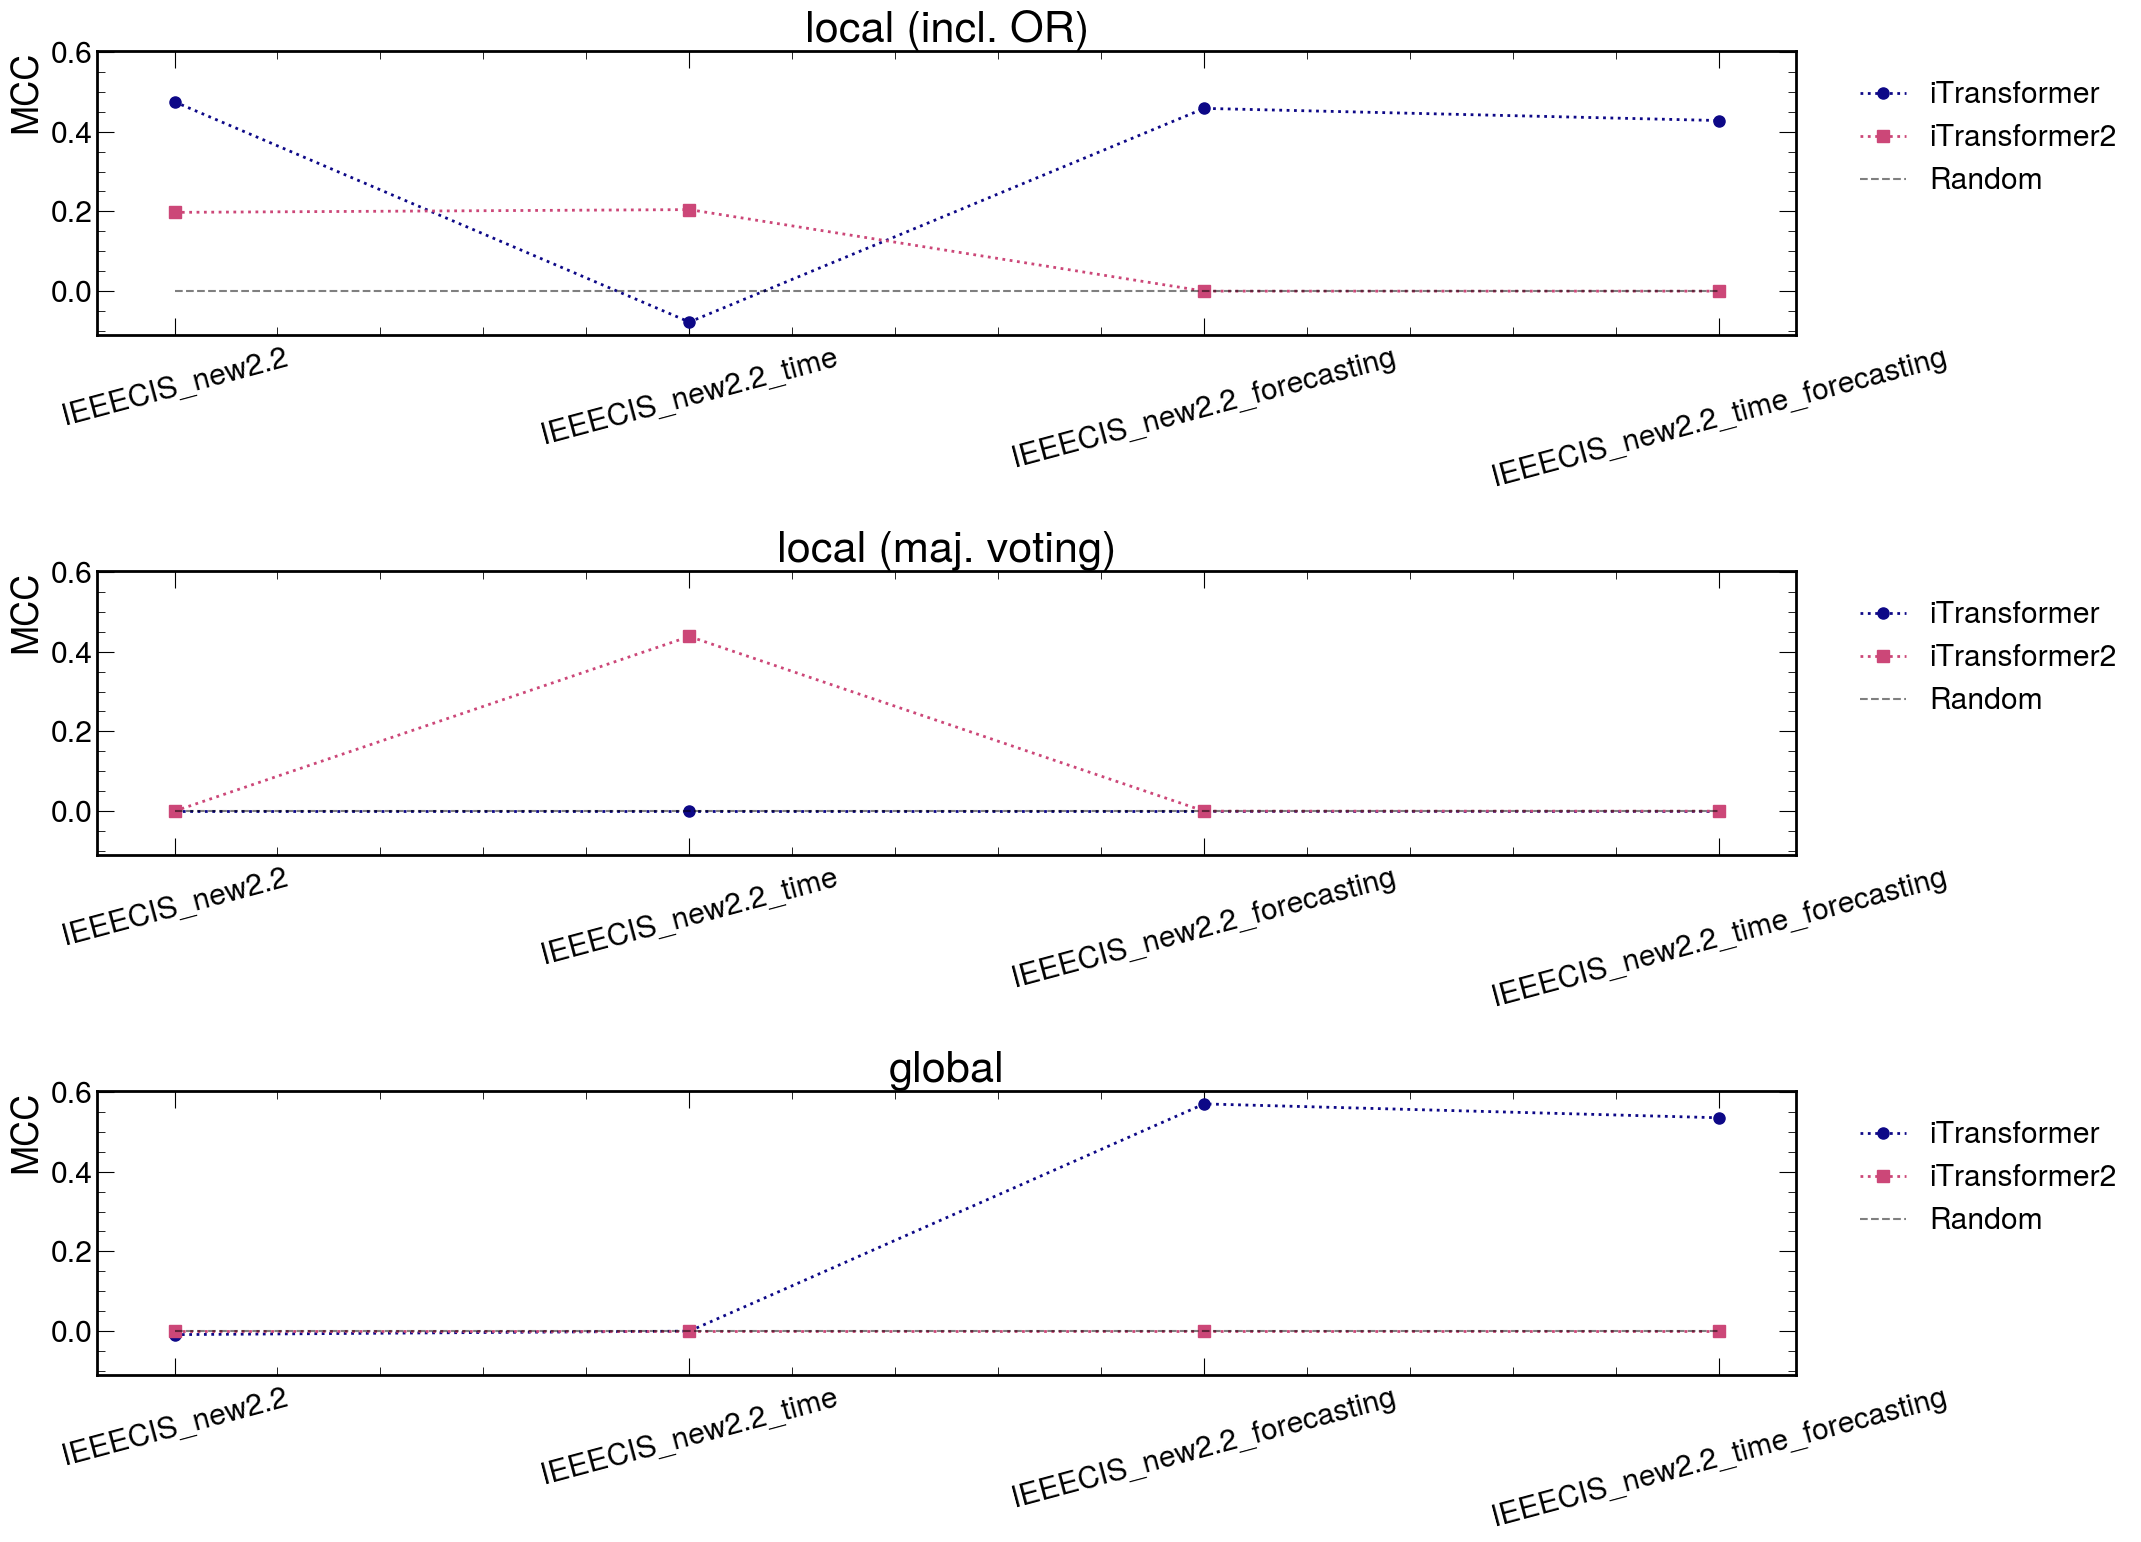

In [24]:
datasets3 = ['IEEECIS_new2.2', 'IEEECIS_new2.2_time', 'IEEECIS_new2.2_forecasting', 'IEEECIS_new2.2_time_forecasting']
    # ['GECCO7', 'GECCO7_time', 'GECCO7_forecasting', 'GECCO7_time_forecasting']
models3 = ['iTransformer', 'iTransformer2']

plot_mcc_scores(comp_results, modes, datasets3, models3) #, name='comp7')

In [ ]:
results['iTransformer_GECCO7_time'] = comp_results['iTransformer_GECCO7_time']
results['iTransformer2_GECCO7_time'] = comp_results['iTransformer2_GECCO7_time']

for m in ['MAD_GAN', 'OmniAnomaly', 'LSTM_AD', 'DAGMM', 'IF', 'None', 'TranAD']:
    key = f'{m}_GECCO7'
    results[f'{m}_GECCO7_time'] = results[key]
print(results.keys())
print(results['IF_GECCO7_time'])

In [62]:
comp_results = {}

dataset = 'GECCO7'
models3 = ['iTransformer']

paths1 = glob.glob(f'iTransformer/iTransformer_{dataset}/*n_window10_*')
paths2 = glob.glob(f'iTransformer/iTransformer_{dataset}/*forecasting*')
paths = paths2 + paths1
paths = np.unique(paths)
paths = np.sort(paths)

keys = []

for path in paths:
    res_path = f'{path}/results/res.csv'
    res = pd.read_csv(res_path)
    key = path.split('/')[1]
    key2 = path.split('/')[2][:10] + path.split('/')[2][25:]
    print(path, key2)
    comp_results[key2] = res.iloc[-3:]
    keys.append(key2)

iTransformer/iTransformer_GECCO7/n_window10_steps1_feats-1_eps10_forecasting n_window10_eps10_forecasting
iTransformer/iTransformer_GECCO7/n_window10_steps1_feats-1_eps20_forecasting n_window10_eps20_forecasting
iTransformer/iTransformer_GECCO7/n_window10_steps1_feats-1_eps5 n_window10_eps5
iTransformer/iTransformer_GECCO7/n_window10_steps1_feats-1_eps5_enc n_window10_eps5_enc
iTransformer/iTransformer_GECCO7/n_window10_steps1_feats-1_eps5_enc_forecasting n_window10_eps5_enc_forecasting
iTransformer/iTransformer_GECCO7/n_window10_steps1_feats-1_eps5_forecasting n_window10_eps5_forecasting
iTransformer/iTransformer_GECCO7/n_window20_steps1_feats-1_eps5_forecasting n_window20_eps5_forecasting


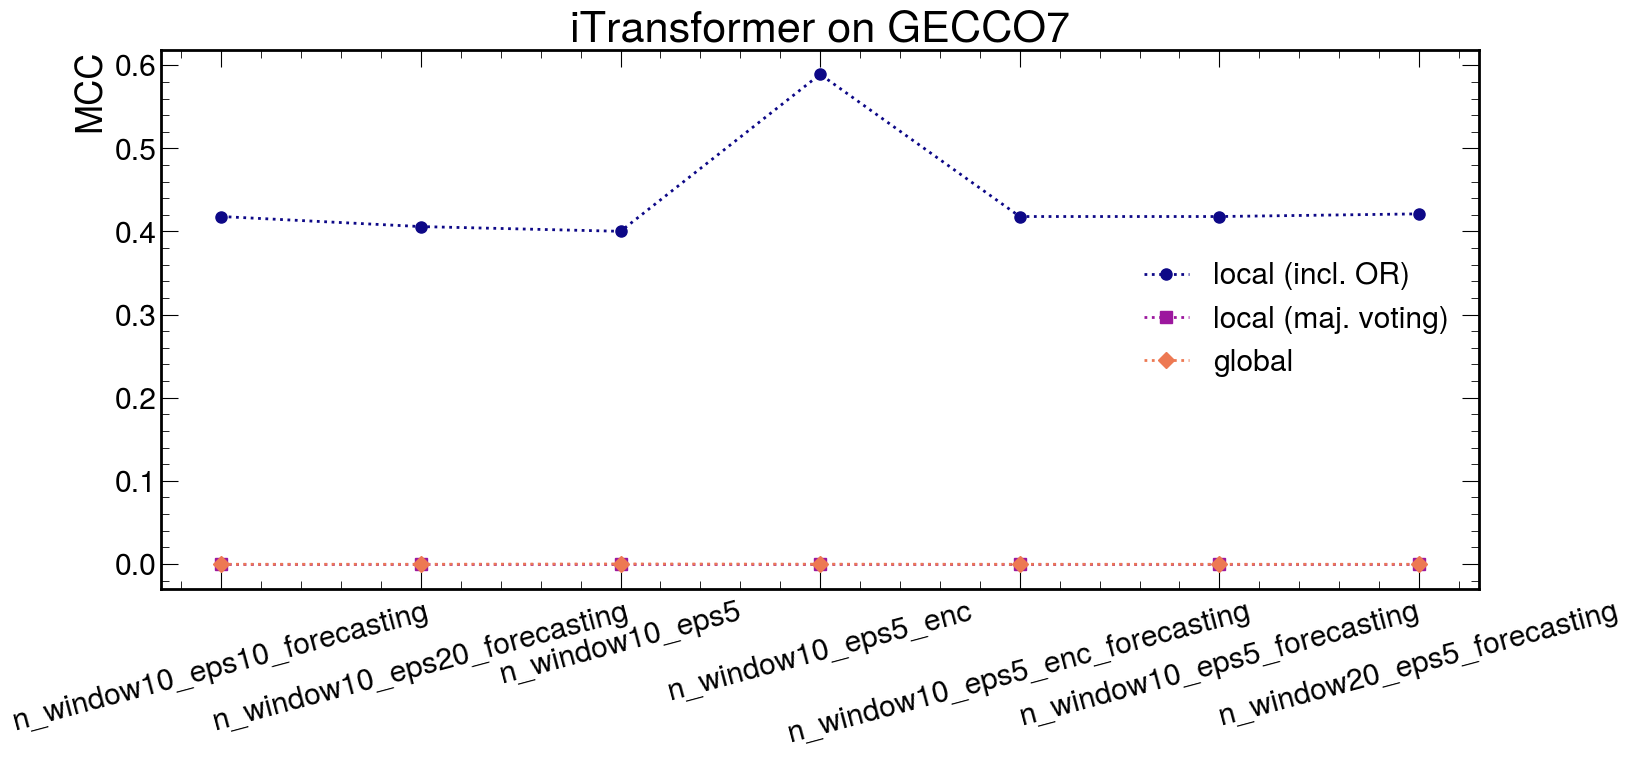

In [61]:
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
colors = plt.cm.plasma(np.linspace(0, 1, 4))
# fig = plt.figure(figsize=(20, 10))

# for j, key in enumerate(comp_results.keys()):
#     print(key)
#     for i, m in enumerate(modes):
#         print(m, comp_results[key]['MCC'].iloc[i])
#         plt.plot(j, comp_results[key]['MCC'].iloc[i], label=m, marker=markers[i], linewidth=2, markersize=8, color=colors[i % len(colors)])
#         plt.xticks(ticks=np.arange(len(comp_results.keys())), labels=comp_results.keys(), rotation=15)
#         plt.ylabel('MCC')
#         plt.title('iTransformer on GECCO7')

# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[-3:], labels[-3:], bbox_to_anchor=(1.02, 1), loc='upper left')
# plt.show()
# Save the entries for every mode and key in a vector
mcc_values = {m: [] for m in modes}

for key in comp_results.keys():
    for i, m in enumerate(modes):
        mcc_values[m].append(comp_results[key]['MCC'].iloc[i])

# Plot the saved entries
fig = plt.figure(figsize=(17, 7))
for i, m in enumerate(modes):
    plt.plot(list(comp_results.keys()), mcc_values[m], label=m, marker=markers[i], linestyle=':', linewidth=2, markersize=8, color=colors[i % len(colors)])
    plt.xticks(ticks=np.arange(len(comp_results.keys())), labels=comp_results.keys(), rotation=15)
    plt.ylabel('MCC')
    plt.title('iTransformer on GECCO7')

# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.legend(loc='center right')
plt.show()